In [179]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 40)

In [180]:
# Collecte des données
data=pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])

In [181]:
# Variables utiles durant tout le notebook
variables = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']
regions = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Corse', 'Grand Est', 'Guadeloupe',
       'Guyane', 'Hauts-de-France', 'La Réunion',
       'Martinique', 'Mayotte', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
regionsmet = ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
#Les données de la Bourgogne diffèrent largement de celles du reste de la France entre 2011 et 2015.
regionsmethorsb = ['Auvergne-Rhône-Alpes', 'Bretagne',
       'Centre-Val de Loire', 'Grand Est', 
        'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur",
       'Île-de-France']
critair = data['CRITAIR'].unique()

In [182]:
# Nous nous restreignons aux véhicules particuliers
data = data[data["CATEGORIE_VEHICULE"] == "Véhicule particulier"].reset_index()

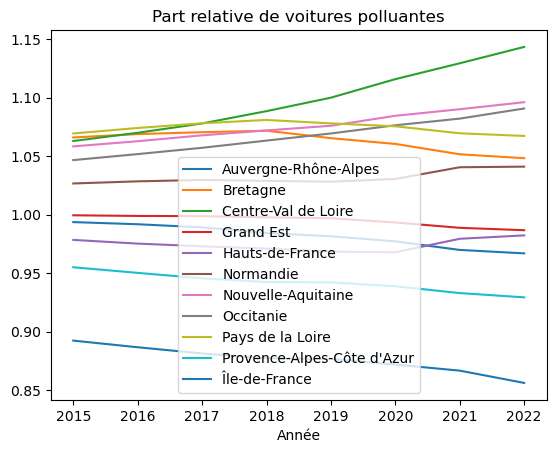

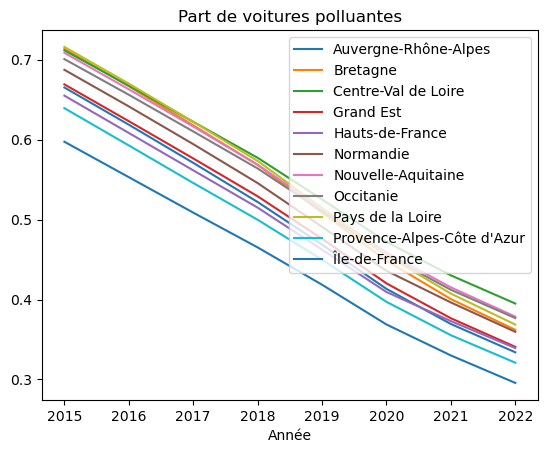

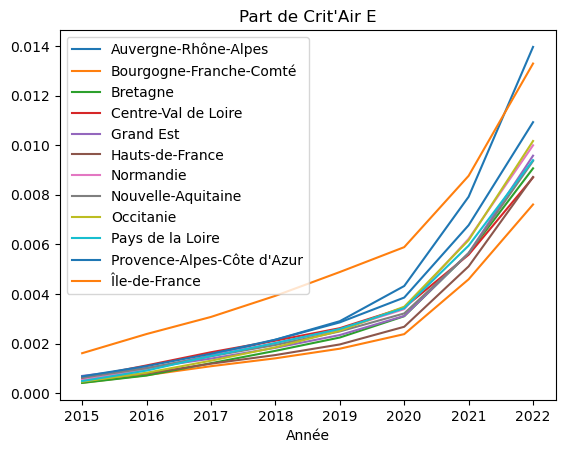

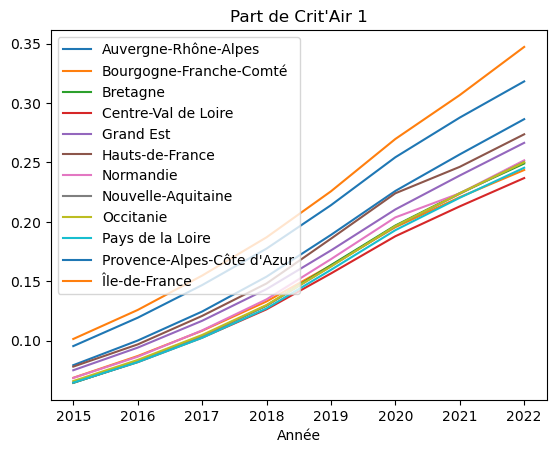

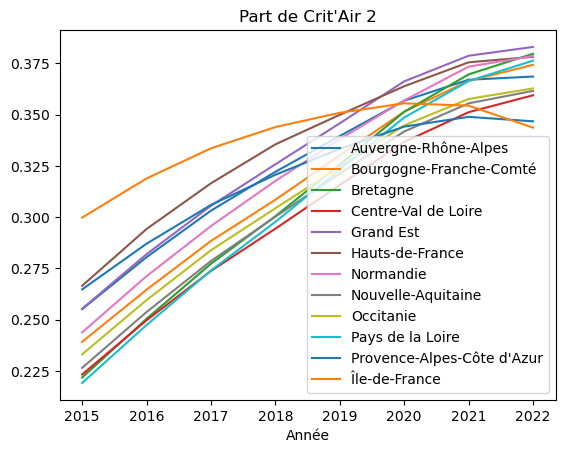

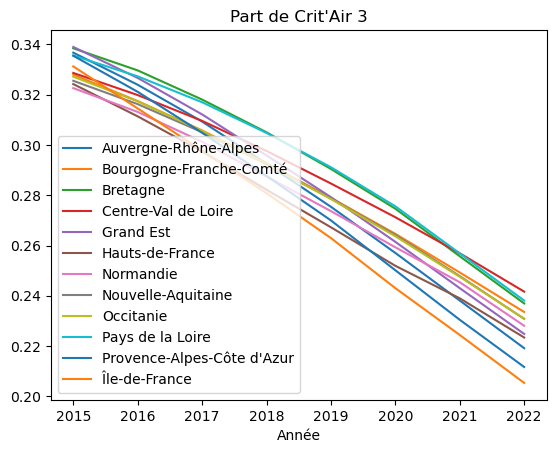

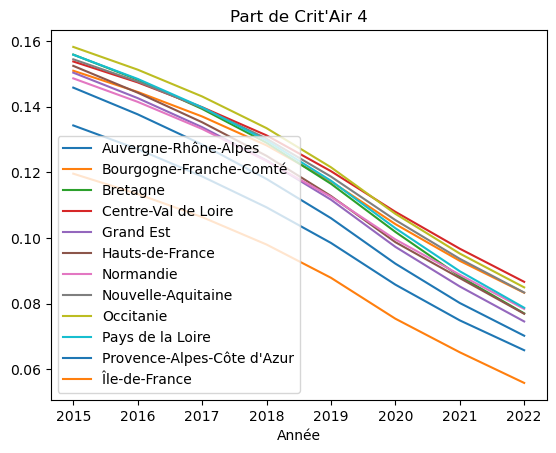

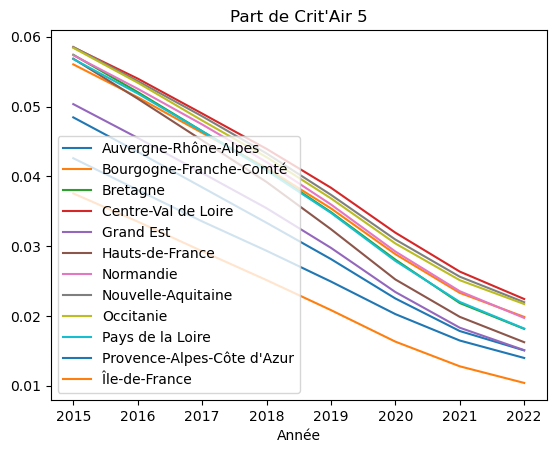

In [183]:
# Le recensement des Crit'Air a gagné en exhaustivité à partir de 2015
Années=[2015,2016,2017,2018,2019,2020,2021,2022]
variables_part = ['PART_2011','PART_2012','PART_2013','PART_2014','PART_2015','PART_2016','PART_2017','PART_2018','PART_2019','PART_2020','PART_2021','PART_2022']

# Création d'une variable "dummy_critair" valant 0 pour les voiture les moins polluantes
data_dummy_critair = data.copy()
data_dummy_critair['DUMMY_CRITAIR'] = data_dummy_critair['CRITAIR'].apply(lambda x : 0 if (x in ["Crit'Air E","Crit'Air 1","Crit'Air 2"]) else 1)

# Groupby pour les ratios
sumregdum = data_dummy_critair.groupby(['REGION_LIBELLE','DUMMY_CRITAIR'])[variables].sum().reset_index()
sumregcrit = data_dummy_critair.groupby(['REGION_LIBELLE','CRITAIR'])[variables].sum().reset_index()
sumreg = data_dummy_critair.groupby(['REGION_LIBELLE'])[variables].sum().reset_index()
sumdum = data_dummy_critair.groupby(['DUMMY_CRITAIR'])[variables].sum().reset_index()
total = np.array(data_dummy_critair[variables].sum())

# Calcul de la part de véhicules moins polluants et plus polluants par année

ratiodum = pd.DataFrame(columns = variables_part)
for k in range(12):
    ratiodum['PART_20'+str(k+11)] = sumdum[sumdum['DUMMY_CRITAIR']==1]['PARC_20'+str(k+11)]/total[k]

# Même calcul, par région
sumreg = sumreg.sort_values(by=['REGION_LIBELLE'])
sumregdum = sumregdum.sort_values(by=['REGION_LIBELLE'])
ratiodumreg = sumreg.merge(sumregdum[sumregdum['DUMMY_CRITAIR']==1], on = ['REGION_LIBELLE'], suffixes = ('','_POLLUANTS'))
for k in range(11,23):
    ratiodumreg['PART_20'+str(k)] = ratiodumreg['PARC_20'+str(k)+'_POLLUANTS']/ratiodumreg['PARC_20'+str(k)]
ratiodumreg = ratiodumreg.set_index('REGION_LIBELLE')
ratiodumreg = ratiodumreg[variables_part]

# Comparaison régional / national par année
ratiocomp = pd.DataFrame()
for k in range(11,23):
    ratiocomp['PART_RELATIVE_20'+str(k)] = ratiodumreg['PART_20'+str(k)]/ratiodum['PART_20'+str(k)].iloc[0]
ratiocomp = ratiocomp[['PART_RELATIVE_2011','PART_RELATIVE_2012','PART_RELATIVE_2013','PART_RELATIVE_2014','PART_RELATIVE_2015','PART_RELATIVE_2016','PART_RELATIVE_2017','PART_RELATIVE_2018','PART_RELATIVE_2019','PART_RELATIVE_2020','PART_RELATIVE_2021','PART_RELATIVE_2022']]

for c in regionsmethorsb:
    v=ratiocomp.loc[c]
    v = v[4:]
    plt.plot(Années,v, label=c)

# Ajout des titres et légendes
plt.title('Part relative de voitures polluantes')
plt.xlabel('Année')
plt.legend()
plt.show()

for c in regionsmethorsb:
    v=ratiodumreg.loc[c]
    v = v[4:]
    plt.plot(Années,v, label=c)

# Ajout des titres et légendes
plt.title('Part de voitures polluantes')
plt.xlabel('Année')
plt.legend()
plt.show()

ratiocrit = sumregcrit.merge(sumreg, on=['REGION_LIBELLE'], suffixes = ('','_TOT'))
for k in range(11,23):
    ratiocrit['PART_20'+str(k)] = ratiocrit['PARC_20'+str(k)]/ratiocrit['PARC_20'+str(k)+'_TOT']

for i in ["Crit'Air E","Crit'Air 1","Crit'Air 2","Crit'Air 3","Crit'Air 4","Crit'Air 5"]:
    for c in regionsmet:
        v=ratiocrit[['REGION_LIBELLE']+variables_part][ratiocrit['CRITAIR']==i].set_index('REGION_LIBELLE').loc[c]
        v = v[4:]
        plt.plot(Années,v, label=c)

    # Ajout des titres et légendes
    plt.title('Part de '+i)
    plt.xlabel('Année')
    plt.legend()
    plt.show()


Concernant les voitures électriques, leur part dans la population de voitures semble croitre exponentiellement.
Cela peut se justifier par le fait que plus de vootures sont produites, plus les coûts diminuent et plus la recherche pour de nouvelles technologies est rentable et donc intensive induisant une équation différentielle de la forme : f'(x) = a.f(x).
Leur part est aujourd'hui de l'ordre d'1%, néanmoins lorsqu'elle sera plus importante, le remplacement des voitures thermiques par des voitures électriques ralentira (voitures thermiques ayant une longue durée de vie, volonté de certaines personnes de ne pas changer de type de véhicule tant qu'ils le peuvent...).
Cela justifie une équation différentielle de la forme : f'(x) = a.f(x)(1-f(x)).
La solution d'une telle équation est de la forme f(x) = exp(ax)/(c+exp(ax)).
Les données disponibles nous permettent de trouver des valeurs probables de a et c avec une méthode de "fitting" : 

Paramètre a ajusté : 0.4284035800845914
Paramètre c ajusté : 16726.157992767003


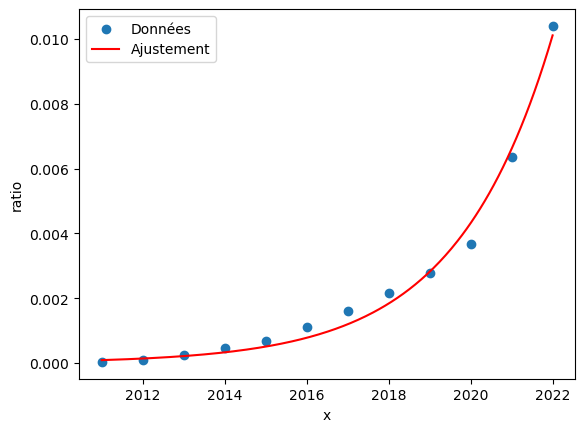

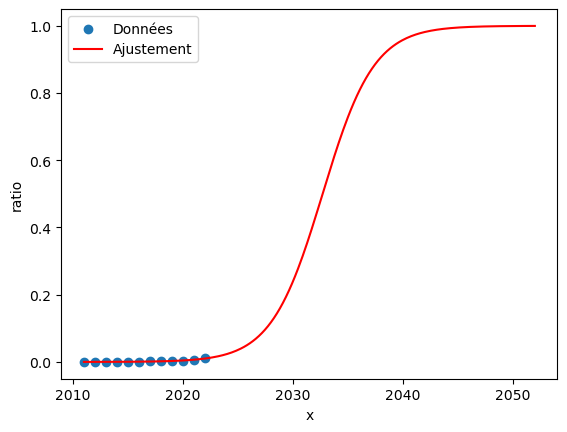

[9.17523649e-05 1.40815113e-04 2.16107517e-04 3.31644648e-04
 5.08919723e-04 7.80880191e-04 1.19799881e-03 1.83751771e-03
 2.81746330e-03 4.31775184e-03 6.61164141e-03 1.01118279e-02
 1.54362110e-02 2.34975982e-02 3.56166582e-02 5.36428504e-02
 8.00352451e-02 1.17796450e-01 1.70079901e-01 2.39275162e-01
 3.25578006e-01 4.25594065e-01 5.32094119e-01 6.35748111e-01
 7.28170538e-01 8.04358941e-01 8.63204857e-01 9.06410248e-01
 9.36966116e-01 9.58008051e-01 9.72233935e-01 9.81732322e-01
 9.88021476e-01 9.92162699e-01 9.94879636e-01]


In [184]:
# Critair E 

données_fit = data[data["CRITAIR"]=="Crit'Air E"][variables].sum().to_frame()
données_fit.columns = ["Crit'Air E"]
données_fit['total']=data[variables].sum().to_frame()
données_fit['ratio'] = données_fit["Crit'Air E"]/données_fit['total']

# Fonction à ajuster
# Le fitting est fait sur les années retranchées de 2010, cela ne change pas mathématiquement le predict mais contourne un float trop grand (exp(2011))
def func(x, a, c):
    return np.exp(a*(x-2010)) / (c + np.exp(a*(x-2010)))

# curve_fit pour ajuster les paramètres
# Des limites (bounds) sont ajoutées pour les paramètres afin d'éviter les problèmes de float trop grands
params, covariance = curve_fit(func, np.arange(2011,2023), données_fit['ratio'], bounds=([0,0], [10,100000]))

# Valeurs ajustées
a_fit, c_fit = params

# Résultats
print(f"Paramètre a ajusté : {a_fit}")
print(f"Paramètre c ajusté : {c_fit}")

# Courbe ajustée
x_values = np.linspace(2011, 2022, 300)
y_values_fit = func(x_values, a_fit, c_fit)
x_graph = np.arange(2011,2023)

plt.scatter(x_graph, données_fit['ratio'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('ratio')
plt.legend()
plt.show()

x_values = np.linspace(2011, 2022+30, 300)
y_values_fit = func(x_values, a_fit, c_fit)
x_graph = np.arange(2011,2023)

plt.scatter(x_graph, données_fit['ratio'], label='Données')
plt.plot(x_values, y_values_fit, color='red', label='Ajustement')
plt.xlabel('x')
plt.ylabel('ratio')
plt.legend()
plt.show()

part_E = func(np.arange(2011,2046), a_fit, c_fit)
print(part_E)

/tmp/ipykernel_327/3042656497.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_reg[arrivee] = données_reg[depart]/tot[i]
/tmp/ipykernel_327/3042656497.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_reg[arrivee] = données_reg[depart]/tot[i]
/tmp/ipykernel_327/3042656497.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  données_reg[arrivee] = données_reg[depart]/tot[i]
/tmp/ipykernel_327/3042656497.py:9: Futu

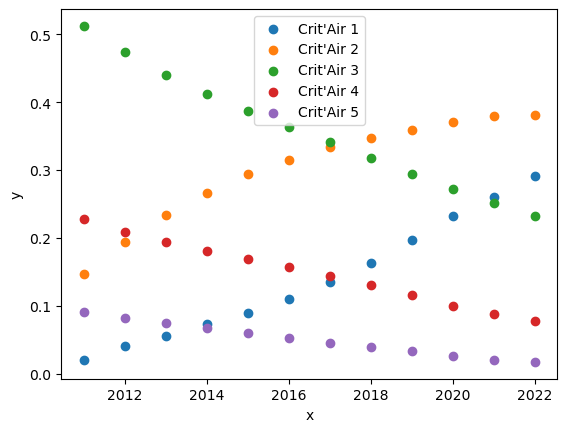

In [185]:
# Part de chaque crit'air parmi les crit'air 1 à 5 (pas de non classées, inconnues très négligeables)
données_reg = data[variables+["CRITAIR"]]
données_reg = données_reg[données_reg["CRITAIR"].isin(["Crit'Air 1", "Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"])].groupby("CRITAIR").sum()
tot = données_reg[variables].sum()
liste_tot = tot.tolist()
for i in range(12):
    depart = "PARC_20"+str(i+11)
    arrivee = "Part_20"+str(i+11)
    données_reg[arrivee] = données_reg[depart]/tot[i]

dpr = données_reg[["Part_2011","Part_2012","Part_2013","Part_2014","Part_2015","Part_2016","Part_2017","Part_2018","Part_2019","Part_2020","Part_2021","Part_2022"]]

x_graph = range(2011,2023)
plt.scatter(x_graph, dpr.loc["Crit'Air 1"], label="Crit'Air 1")
plt.scatter(x_graph, dpr.loc["Crit'Air 2"], label="Crit'Air 2")
plt.scatter(x_graph, dpr.loc["Crit'Air 3"], label="Crit'Air 3")
plt.scatter(x_graph, dpr.loc["Crit'Air 4"], label="Crit'Air 4")
plt.scatter(x_graph, dpr.loc["Crit'Air 5"], label="Crit'Air 5")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [186]:
def min0max1(x):
    y=[]
    for i in range(len(x)):
        if x[i] < 0:
            y.append(0)
        elif x[i] > 1:
            y.append(1)
        else:
            y.append(x[i])
    return(np.array(y))

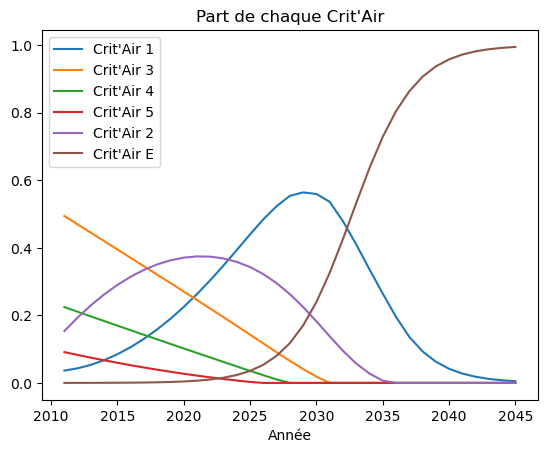

In [187]:
# 5 modèles pour les critair 1 à 5
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()
model4 = LinearRegression()
model5 = LinearRegression()

# Entraînez le modèle sur l'ensemble d'entraînement
years_fit = np.arange(2011, 2023).reshape(-1, 1)
years_squared_fit = years_fit ** 2
x_fit = np.hstack((years_fit, years_squared_fit))
model1.fit(x_fit, np.array(dpr.loc["Crit'Air 1"]))
model2.fit(x_fit, np.array(dpr.loc["Crit'Air 2"]))
model3.fit(years_fit, np.array(dpr.loc["Crit'Air 3"]))
model4.fit(x_fit, np.array(dpr.loc["Crit'Air 4"]))
model5.fit(x_fit, np.array(dpr.loc["Crit'Air 5"]))

# Prédictions sur l'ensemble de test
years_pred = np.arange(2011, 2046).reshape(-1, 1)
years_squared_pred = years_pred ** 2
x_pred = np.hstack((years_pred, years_squared_pred))
# La prédiction du nombre de Crit'Air 3 est plus satisfaisante sans les années au carré, car en les ajoutant, elle devient non monotone
y_pred1 = model1.predict(x_pred)
y_pred2 = model2.predict(x_pred)
y_pred3 = model3.predict(years_pred)
y_pred4 = model4.predict(x_pred)
y_pred5 = model5.predict(x_pred)

# Une des parts est calculée à partir des autres pour garantit une somme valant 1.
# Les 5 scénarios ont été testés et le cas le plus satisfaisant est de calculer la part de crit'air 1 à partir des autres.
crit2 = min0max1(y_pred2)
crit3 = min0max1(y_pred3)
crit4 = min0max1(y_pred4)
crit5 = min0max1(y_pred5)
crit1 = [1]*35-crit2-crit3-crit4-crit5

# La part de Crit'Air E est prise en compte pour calculer la part dans toute la population de voitures
crit1_E = crit1*(1-part_E) 
crit2_E = crit2*(1-part_E) 
crit3_E = crit3*(1-part_E) 
crit4_E = crit4*(1-part_E) 
crit5_E = crit5*(1-part_E) 

x_graph = np.arange(2011, 2046)
plt.plot(x_graph, crit1_E, label="Crit'Air 1")
plt.plot(x_graph, crit3_E, label="Crit'Air 3")
plt.plot(x_graph, crit4_E, label="Crit'Air 4")
plt.plot(x_graph, crit5_E, label="Crit'Air 5")
plt.plot(x_graph, crit2_E, label="Crit'Air 2")
plt.plot(x_graph, part_E, label="Crit'Air E")
plt.title("Part de chaque Crit'Air")
plt.xlabel('Année')
plt.legend()
plt.show()

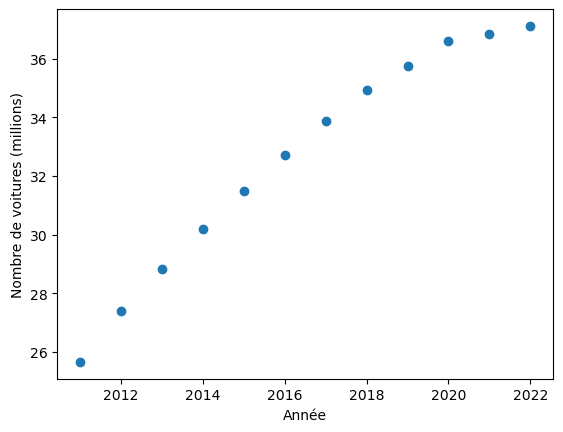

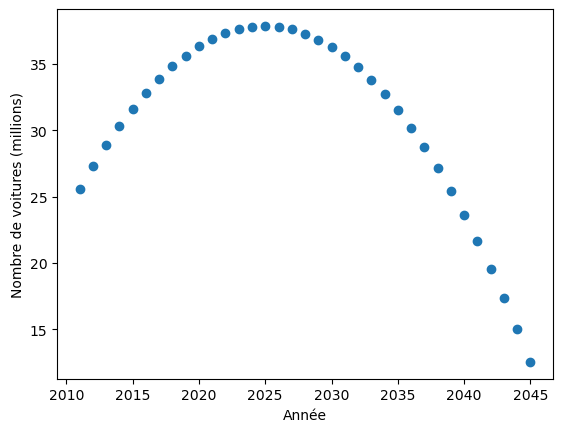

array([ 2.55311816e+08, -6.30413899e+04])

In [188]:
#Nombre total de voiture : nous considérerons ici que la demande de voiture va suivre jusqu'en 2045 sa tendance actuelle.

years_fit = np.arange(2011, 2023).reshape(-1, 1)
years_squared_fit = years_fit ** 2
x_fit = np.hstack((years_fit, years_squared_fit))

# En traçant le graphique, on constate une augmentation du nombre de voiture de plus en plus lente (concavité du nombre de voiture en fonction de l'année)

plt.scatter(years_fit, (np.array(tot))/1e6)
plt.xlabel('Année')
plt.ylabel('Nombre de voitures (millions)')
plt.show()

# Une régression linéaire sur l'année ne prendrait pas en compte la réduction de la croissance.
# Nous pouvons donc essayer une régression prenant en compte le carrée de l'année.

model = LinearRegression()
model.fit(x_fit, np.array(tot))

years_pred = np.arange(2011, 2046).reshape(-1, 1)
years_squared_pred = years_pred ** 2
x_pred = np.hstack((years_pred, years_squared_pred))

y_pred = model.predict(x_pred)

plt.scatter(years_pred, y_pred/1e6)
plt.xlabel('Année')
plt.ylabel('Nombre de voitures (millions)')
plt.show()

# Nous constatons que la courbure induite est très forte et donne une réduction importante du nombre de voitures.
# Cela ne correspond pas à ce qui est attendu au niveau français.

model.coef_

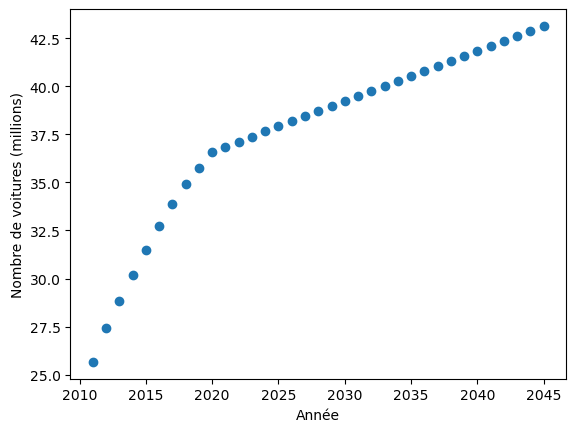

array([261411.5])

In [189]:
# Une solution pour contourner ce problème est de considérer que l'augmentation sera constante après 2020 (fin du choc Covid)

years_fit = np.arange(2020, 2023).reshape(-1, 1)

model = LinearRegression()
model.fit(years_fit, np.array(tot)[9:])

years_pred = np.arange(2020, 2046).reshape(-1, 1)

y_pred = model.predict(years_pred)

nb_voitures_pred = np.append(np.array(tot)[:9],(y_pred))

plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures_pred/1e6)
plt.xlabel('Année')
plt.ylabel('Nombre de voitures (millions)')
plt.show()

# Le nombre de voitures obtenues dans les prochaines décennies est du bon ordre de grandeur

model.coef_

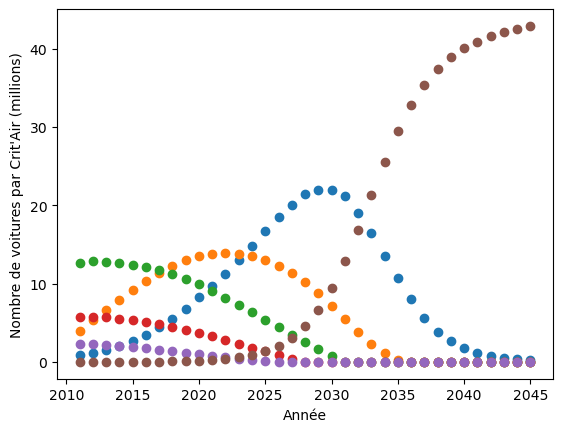

In [190]:
nb_voitures1 = nb_voitures_pred*crit1_E
nb_voitures2 = nb_voitures_pred*crit2_E
nb_voitures3 = nb_voitures_pred*crit3_E
nb_voitures4 = nb_voitures_pred*crit4_E
nb_voitures5 = nb_voitures_pred*crit5_E
nb_voituresE = nb_voitures_pred*part_E

plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures1/1e6)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures2/1e6)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures3/1e6)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures4/1e6)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voitures5/1e6)
plt.scatter(np.arange(2011, 2046).reshape(-1, 1), nb_voituresE/1e6)
plt.xlabel('Année')
plt.ylabel("Nombre de voitures par Crit'Air (millions)")
plt.show()

In [191]:
calcul_part_diesel = data[["CARBURANT","PARC_2022"]].groupby("CARBURANT").sum()
part_diesel = calcul_part_diesel.loc["Diesel"].iloc[0]/(calcul_part_diesel.loc["Diesel"].iloc[0]+calcul_part_diesel.loc["Essence"].iloc[0])
part_diesel

0.5791841399687028

In [192]:
df_emissions = pd.read_csv("emission_calculees.csv")
df_emissions

,Unnamed: 0,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Norme,CARBURANT,Hydrocarbures (HC)
0,0,-,2 720,-,-,970,Euro 1,Diesel,NaN
1,1,-,1 000,-,-,700,Euro 2,Diesel,NaN
2,2,500,640,-,-,560,Euro 3,Diesel,NaN
3,3,250,500,-,-,300,Euro 4,Diesel,NaN
4,4,180,500,-,-,230,Euro 5a,Diesel,NaN
5,5,180,500,-,-,230,Euro 5b,Diesel,NaN
6,6,80,500,-,-,170,Euro 6b,Diesel,NaN
7,7,80,500,-,-,170,Euro 6c,Diesel,NaN
8,8,80,500,-,-,170,Euro 6d -TEMP,Diesel,NaN
9,9,80,500,-,-,170,Euro 6d,Diesel,NaN


In [193]:
emissions_par_critair = pd.DataFrame(columns = ['NOx', 'CO'])
emissions_par_critair.loc["Crit'Air E"] = [0,0]
emissions_par_critair.loc["Crit'Air 1"] = [60,1000]
emissions_par_critair.loc["Crit'Air 2"] = [80*(1-part_diesel)+130*part_diesel,1000*(1-part_diesel)+500*part_diesel]
emissions_par_critair.loc["Crit'Air 3"] = [150*(1-part_diesel)+250*part_diesel,2200*(1-part_diesel)+500*part_diesel]
emissions_par_critair.loc["Crit'Air 4"] = [500,640]
emissions_par_critair.loc["Crit'Air 5"] = [500,1000]
emissions_par_critair

,NOx,CO
Crit'Air E,0.000000,0.000000
Crit'Air 1,60.000000,1000.000000
Crit'Air 2,108.959207,710.407930
Crit'Air 3,207.918414,1215.386962
Crit'Air 4,500.000000,640.000000
Crit'Air 5,500.000000,1000.000000


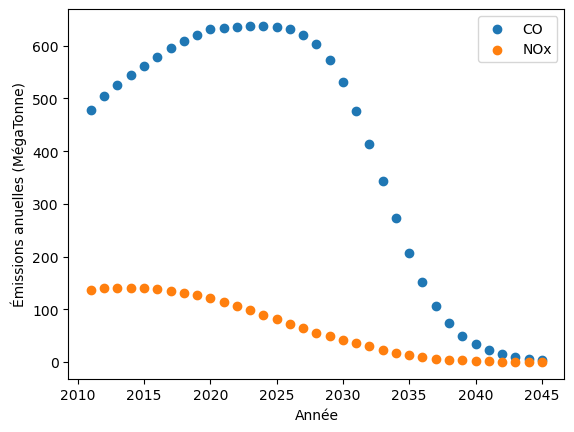

In [194]:
#Calcul des émissions totales avec l'hypothèse d'un nombre de km par véhicule moyen constant (19000)
emissions_totales_NOx = np.zeros(35)
emissions_totales_CO = np.zeros(35)
for i in range(35):
    emissions_totales_NOx[i] = 19000*(nb_voituresE[i]*emissions_par_critair.loc["Crit'Air E"]["NOx"] + nb_voitures1[i]*emissions_par_critair.loc["Crit'Air 1"]["NOx"] + nb_voitures2[i]*emissions_par_critair.loc["Crit'Air 2"]["NOx"] + nb_voitures3[i]*emissions_par_critair.loc["Crit'Air 3"]["NOx"] + nb_voitures4[i]*emissions_par_critair.loc["Crit'Air 4"]["NOx"] + nb_voitures5[i]*emissions_par_critair.loc["Crit'Air 5"]["NOx"])
    emissions_totales_CO[i] = 19000*(nb_voituresE[i]*emissions_par_critair.loc["Crit'Air E"]["CO"] + nb_voitures1[i]*emissions_par_critair.loc["Crit'Air 1"]["CO"] + nb_voitures2[i]*emissions_par_critair.loc["Crit'Air 2"]["CO"] + nb_voitures3[i]*emissions_par_critair.loc["Crit'Air 3"]["CO"] + nb_voitures4[i]*emissions_par_critair.loc["Crit'Air 4"]["CO"] + nb_voitures5[i]*emissions_par_critair.loc["Crit'Air 5"]["CO"])

plt.scatter(np.arange(2011, 2046), emissions_totales_CO/1e12, label = "CO")
plt.scatter(np.arange(2011, 2046), emissions_totales_NOx/1e12, label = "NOx")
plt.xlabel('Année')
plt.ylabel('Émissions anuelles (MégaTonne)')
plt.legend()
plt.show()